## SI-Score Dataset

Let us start by training a simple CNN model on this dataset. I'll start by the `object_size` dataset. All datasets can be downloaded from [here](https://github.com/google-research/si-score?tab=readme-ov-file).

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from IPython.display import clear_output

In [2]:
data_dir = '../../object_size'
classes = os.listdir(data_dir)
num_classes = len(classes)

print(num_classes, classes[:5])

64 ['lipstick', 'burrito', 'cello', 'mushroom', 'lemon']


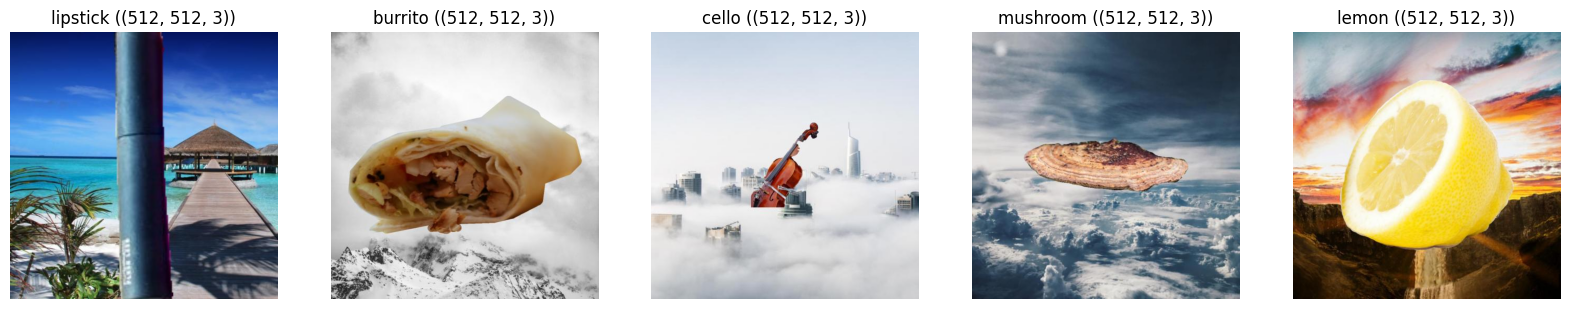

In [3]:
images = [
    Image.open(f'{data_dir}/{classes[i]}/{os.listdir(f"{data_dir}/{classes[i]}")[0]}')
    for i in range(5)
]
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, img in enumerate(images):
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(classes[i] + f' ({np.array(img).shape})')

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),        # Convert PIL image to tensor (0-1)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [5]:
dataset = ImageFolder(data_dir, transform=transform)

In [6]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Training a CNN

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 128 * 128, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
learning_rate = 1e-4
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 1
train_losses = []

In [10]:
def dynamic_plot(losses):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(losses))), y=losses, mode='lines+markers'))
    fig.update_layout(title='', xaxis_title='Optimization Step', yaxis_title='Train Loss (CE)')
    fig.update_layout(plot_bgcolor='white')
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_layout(width=800, height=500)
    fig.update_traces(line=dict(width=2))
    return fig

In [11]:
train = False
model_path = 'model.pth'

if train:
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            clear_output(wait=True)
            dynamic_plot(train_losses).show()
    # save
    torch.save(model.state_dict(), model_path)

In [12]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [13]:
evaluate = False

if evaluate:
    model.eval()
    correct, total = 0, 0
    for images, labels in tqdm.tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += sum((predicted == labels).float())
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

## Modularity Loss Function

I'll first start by just measuring some information-related metrics in a trained model and contrast them with those for an untrained model, and then figure out what kinds of metrics can be good for:

- Tracking during training
- Adding to the loss function for modularity

In [24]:
trained_model = CNN(num_classes).to(device)
untrained_model = CNN(num_classes).to(device)

trained_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [25]:
trained_model

CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=524288, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [26]:
# Dictionary to store activations
activations = {'trained': {}, 'untrained': {}}

# Hook function to capture activations
def get_activation(name, model_type):
    def hook(model, input, output):
        # average over batches
        if name not in activations[model_type]:
            activations[model_type][name] = output.mean(dim=0).detach().cpu()
        else:
            activations[model_type][name] += output.mean(dim=0).detach().cpu()
    return hook

# first, remove all hooks from the model
trained_model._forward_hooks.clear()
untrained_model._forward_hooks.clear()

In [27]:
layer_names_f = ['Conv2d_1', 'ReLU_1', 'MaxPool2d_1', 'Conv2d_2', 'ReLU_2', 'MaxPool2d_2']

for idx, name in enumerate(layer_names_f):
    trained_model.features[idx].register_forward_hook(get_activation(name, 'trained'))
    untrained_model.features[idx].register_forward_hook(get_activation(name, 'untrained'))

layer_names_c = ['Linear_1', 'ReLU_3', 'Linear_2']
for idx, name in enumerate(layer_names_c):
    trained_model.classifier[idx].register_forward_hook(get_activation(name, 'trained'))
    untrained_model.classifier[idx].register_forward_hook(get_activation(name, 'untrained'))

In [28]:
batch_count = 0

for images, labels in test_loader:
    batch_count += 1
    images = images.to(device)
    labels = labels.to(device)
    _ = trained_model(images)
    _ = untrained_model(images)
    print('.', end='')

...................................................................................................................................................................................................................................................................................................

In [ ]:
# average activations 
for key in activations.keys():
    for layer in activations[key].keys():
        activations[key][layer] /= batch_count

In [ ]:
# print shape of activations
print('Trained model activations:')
for key, value in activations['trained'].items():
    print(f'{key:<15}{value.shape}')

Trained model activations:
Conv2d_1       torch.Size([16, 512, 512])
ReLU_1         torch.Size([16, 512, 512])
MaxPool2d_1    torch.Size([16, 256, 256])
Conv2d_2       torch.Size([32, 256, 256])
ReLU_2         torch.Size([32, 256, 256])
MaxPool2d_2    torch.Size([32, 128, 128])
Linear_1       torch.Size([256])
ReLU_3         torch.Size([256])
Linear_2       torch.Size([64])


In [ ]:
def conditional_entropy(act1, act2, num_bins=10):

    def discretize_activations(activations, bins=10):
        min_val = activations.min().item()
        max_val = activations.max().item()
        bins = torch.linspace(min_val, max_val, bins)
        discretized = torch.bucketize(activations, bins) - 1  # bucketize indexes from 1, subtract 1 to start from 0
        return discretized

    def joint_distribution(act1, act2, num_bins=10):
        joint_hist = torch.zeros((num_bins, num_bins))

        for i in range(act1.size(0)):
            for j in range(act1.size(1)):
                joint_hist[act1[i, j], act2[i, j]] += 1

        # normalize to get probabilities
        joint_distribution = joint_hist / joint_hist.sum()
        return joint_distribution

    def marginals(joint_dist):
        marginal_x = torch.sum(joint_dist, dim=1)  # Sum over columns to get P(X)
        marginal_y = torch.sum(joint_dist, dim=0)  # Sum over rows to get P(Y)
        return marginal_x, marginal_y

    epsilon = 1e-8
    conditional_entropy = 0.0
    act1 = discretize_activations(act1, num_bins)
    act2 = discretize_activations(act2, num_bins)

    joint_dist = joint_distribution(act1, act2, num_bins)
    marginal_x, marginal_y = marginals(joint_dist)
    for i in range(num_bins):
        for j in range(num_bins):
            if joint_dist[i, j] > 0:
                conditional_entropy -= joint_dist[i, j] * torch.log(joint_dist[i, j] / (marginal_y[j] + epsilon) + epsilon)
    
    return conditional_entropy

def entropy(act):
    # probs
    probs = torch.histc(act, bins=10) / act.numel()
    # entropy
    entropy = -torch.sum(probs * torch.log(probs + 1e-8))
    return entropy

def mutual_information(act1, act2, num_bins=10):
    return entropy(act1) - conditional_entropy(act1, act2, num_bins)

def joint_entropy(act1, act2, num_bins=10):
    return conditional_entropy(act1, act2, num_bins) + entropy(act2)

In [23]:
print(f"{'Component':<15} | {'Trained':<15} | {'Untrained':<15} | {'Diff':<15} | {'Size'}", end='\n\n')

for layer_name in layer_names_f + layer_names_c:
    trained_entropy = round(entropy(activations['trained'][layer_name]), 6)
    untrained_entropy = round(entropy(activations['untrained'][layer_name]), 6)
    # activation space size
    size = activations['trained'][layer_name].shape
    diff = round(trained_entropy - untrained_entropy, 6)
    print(f"{str(layer_name):<15} | {trained_entropy:<15} | {untrained_entropy:<15} | {diff:<15} | {size}")

Component       | Trained         | Untrained       | Diff            | Size

Conv2d_1        | 12.47066        | 12.473813       | -0.003153       | torch.Size([16, 512, 512])
ReLU_1          | 12.474945       | 12.475678       | -0.000733       | torch.Size([16, 512, 512])
MaxPool2d_1     | 11.088557       | 11.089325       | -0.000768       | torch.Size([16, 256, 256])
Conv2d_2        | 11.088205       | 11.090039       | -0.001834       | torch.Size([32, 256, 256])
ReLU_2          | 11.090027       | 11.090219       | -0.000192       | torch.Size([32, 256, 256])
MaxPool2d_2     | 9.703685        | 9.703913        | -0.000228       | torch.Size([32, 128, 128])
Linear_1        | 0.023787        | 5.543478        | -5.519691       | torch.Size([256])
ReLU_3          | 0.024333        | 5.544671        | -5.520338       | torch.Size([256])
Linear_2        | 3.178024        | 4.157959        | -0.979935       | torch.Size([64])


### Some observations:

* The untrained model has higher entropy in its activations for all components. This is expected since training should reduce the randomness of activations and increase the information (thereby reducing entropy).
* The difference is lesser for CNN components (with much larger sizes), and pretty significant for MLP (smaller sizes).

Now, let's try to look at other things: conditional entropy and mutual information. The main issues here are the following:

- The activations are not all the same size.
- Their dimensions are pretty large (order of 10^7).

Thus, we'll need to do something to make them tractable. Binning (histograms) and sampling seem to be two ideas.

In [24]:
P_X = torch.randn(10000000, device='cuda')
P_Y = torch.randn(5000000, device='cuda')
P_X = F.softmax(P_X, dim=0)
P_Y = F.softmax(P_Y, dim=0)

In [25]:
H_X = torch.distributions.Categorical(probs=P_X).entropy()
H_Y = torch.distributions.Categorical(probs=P_Y).entropy()

print(f'H(X): {H_X:.4f}, H(Y): {H_Y:.4f}')

H(X): 15.3590, H(Y): 14.8450


In [26]:
from collections import defaultdict

In [28]:
import einops

In [29]:
mutual_informations = {}
conditional_entropies = {}

In [30]:
for mod in ['trained', 'untrained']:
    all_layers = list(activations[mod].keys())
    for layer_i in all_layers:
        for layer_j in all_layers:
            x = activations[mod][layer_i]
            y = activations[mod][layer_j]
            if x.dim() > 2: x = einops.einsum(x, 'b c h ... -> b c h')
            x = x.flatten()
            if y.dim() > 2: y = einops.einsum(y, 'b c h ... -> b c h')
            y = y.flatten()

            x = F.softmax(x, dim=0)
            y = F.softmax(y, dim=0)
            H_X = torch.distributions.Categorical(probs=x).entropy()
            H_Y = torch.distributions.Categorical(probs=y).entropy()
            H_XY = joint_entropy(x, y, 100000)
            mutual_info = H_X + H_Y - H_XY
            conditional_entropy = H_XY - H_Y

            mutual_informations[(mod, layer_i, layer_j)] = mutual_info
            conditional_entropies[(mod, layer_i, layer_j)] = conditional_entropy

            print(f'.', end='')

..................................................................................................................................................................

In [31]:
layer_names = layer_names_f + layer_names_c
print(layer_names)

['Conv2d_1', 'ReLU_1', 'MaxPool2d_1', 'Conv2d_2', 'ReLU_2', 'MaxPool2d_2', 'Linear_1', 'ReLU_3', 'Linear_2']


In [44]:
def heatmap(data, title, layer_order):
    # Separate data based on 'trained' variable
    trained_data = {(layer1, layer2): value for (trained, layer1, layer2), value in data.items() if trained == 'trained'}
    untrained_data = {(layer1, layer2): value for (trained, layer1, layer2), value in data.items() if trained == 'untrained'}

    # Initialize matrices
    trained_matrix = np.zeros((len(layer_order), len(layer_order)))
    untrained_matrix = np.zeros((len(layer_order), len(layer_order)))
    
    # Fill the matrices with the data values
    for (layer1, layer2), value in trained_data.items():
        i = layer_order.index(layer1)
        j = layer_order.index(layer2)
        trained_matrix[i, j] = value
        
    for (layer1, layer2), value in untrained_data.items():
        i = layer_order.index(layer1)
        j = layer_order.index(layer2)
        untrained_matrix[i, j] = value
    
    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Trained", "Untrained"))

    # Add heatmaps
    fig.add_trace(go.Heatmap(
        z=trained_matrix,
        x=layer_order,
        y=layer_order,
        colorscale='RdBu'
    ), row=1, col=1)
    
    fig.add_trace(go.Heatmap(
        z=untrained_matrix,
        x=layer_order,
        y=layer_order,
        colorscale='RdBu'
    ), row=1, col=2)
    
    # Update layout
    fig.update_layout(
        title=title,
        xaxis_nticks=36,
        yaxis_nticks=36,
        width=1000,  # Adjust width to fit both heatmaps
        height=500
    )
    
    return fig

In [45]:
heatmap(mutual_informations, 'Mutual Information', layer_names).show()

In [46]:
heatmap(conditional_entropies, 'Conditional Entropy', layer_names).show()

### Observations

- Training the model reduces the mutual information between model components.
- It also reduces the conditional entropy.

Notes:
- Will need to think about what it all means and how it can inform our proposal.
- For some reason, the conditional entropy for some components comes out to be negative. This shouldn't happen -- maybe sampling has something to do with it.

## Information in SAEs

In [47]:
from datasets import load_dataset  
from transformer_lens import HookedTransformer
from sae_lens import SAE

model = HookedTransformer.from_pretrained("gpt2-small", device = device)

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience. 
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gpt2-small-res-jb", # see other options in sae_lens/pretrained_saes.yaml
    sae_id = "blocks.8.hook_resid_pre", # won't always be a hook point
    device = device
)

Loaded pretrained model gpt2-small into HookedTransformer


In [48]:
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset(
    path = "NeelNanda/pile-10k",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset= dataset,# type: ignore
    tokenizer = model.tokenizer, # type: ignore
    streaming=True,
    max_length=sae.cfg.context_size,
    add_bos_token=sae.cfg.prepend_bos,
)

Using the latest cached version of the dataset since NeelNanda/pile-10k couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/b-sgolechha/.cache/huggingface/datasets/NeelNanda___pile-10k/default/0.0.0/127bfedcd5047750df5ccf3a12979a47bfa0bafa (last modified on Thu Jun 20 07:47:31 2024).


In [50]:
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

with torch.no_grad():
    # activation store can give us tokens.
    batch_tokens = token_dataset[:32]["tokens"]
    _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

    # Use the SAE
    feature_acts = sae.encode(cache[sae.cfg.hook_name])
    sae_out = sae.decode(feature_acts)

    # save some room
    del cache

    # ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
    l0 = (feature_acts[:, 1:] > 0).float().sum(-1).detach()
    
    # entropy of the activations
    entropy_acts = [compute_entropy((feature_acts[z, 1:] > 0).float().sum(-1)) for z in range(feature_acts.shape[0])]
    entropy_sae_out = [compute_entropy((sae_out[z, 1:] > 0).float().sum(-1)) for z in range(sae_out.shape[0])]

In [57]:
feature_acts.shape, sae_out.shape

(torch.Size([32, 128, 24576]), torch.Size([32, 128, 768]))

In [51]:
print("average l0", l0.mean().item())
px.histogram(l0.flatten().cpu().numpy()).show()

average l0 68.78961944580078


In [56]:
len(entropy_acts), entropy_acts[0]

(32, 2.551616091750475e-07)

In [58]:
# plot the entropy of the activations
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(entropy_acts))), y=entropy_acts, mode='lines+markers', name="Activations"))
fig.add_trace(go.Scatter(x=list(range(len(entropy_sae_out))), y=entropy_sae_out, mode='lines+markers', name="SAE Output"))
fig.update_layout(title='Information in SAE features at various token positions', xaxis_title='Token Position', yaxis_title='Entropy')
fig.show()

### Observations

- For various token positions in the training data, the SAE features seem to carry different amounts of information.
- There could be an interesting pattern under this that is worth exploring further.

Continuing with modularity metrics in `si_score_modularity_metric.ipynb`.